In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv
    
    
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

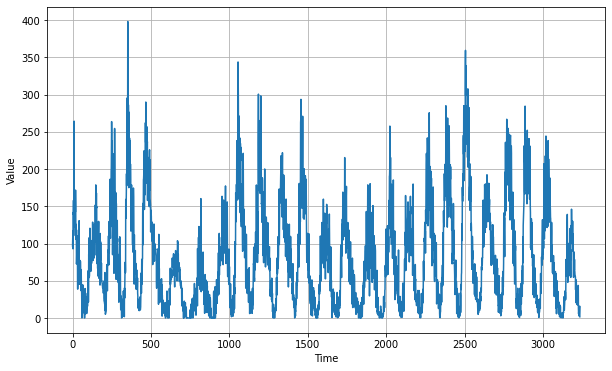

In [2]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

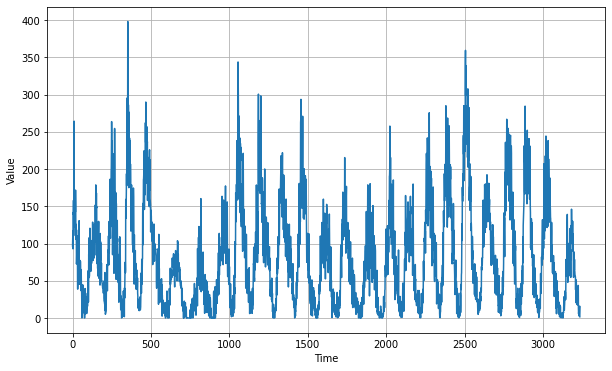

In [3]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 488ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 3s 244ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 3s 243ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 3s 254ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 3s 229ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 3s 284ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 3s 281ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 3s 247ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 3s 270ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 3s 234ms/step - loss: 24.9825 - mae: 25.0321
Epoch 83/100
12/12 [==============================] - 3s 235ms/step - loss: 31.7503 - mae: 32.2966
Epoch 84/100
12/12 [==============================] - 3s 235ms/step - loss: 29.9318 - mae: 30.6369
Epoch 85/100
12/12 [==============================] - 3s 226ms/step - loss: 24.6131 - mae: 25.2771
Epoch 86/100
12/12 [==============================] - 3s 226ms/step - loss: 25.6726 - mae: 26.0755
Epoch 87/100
12/12 [==============================] - 3s 226ms/step - loss: 25.1870 - mae: 25.5615
Epoch 88/100
12/12 [==============================] - 3s 226ms/step - loss: 27.5570 - mae: 27.7545
Epoch 89/100
12/12 [==============================] - 3s 226ms/step - loss: 58.2509 - mae: 58.8927
Epoch 90/100
12/12 [==============================] - 3s 227ms/step - loss: 56.2949 - mae: 56.7446
Epoch 91/100
12/12 [==============================] - 3s 227ms/step - loss: 52.8612 - mae: 53.3595
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

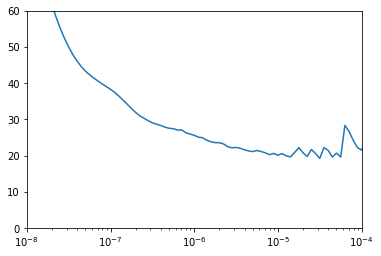

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 164ms/step - loss: 37.8969 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 2s 73ms/step - loss: 24.0752 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 2s 76ms/step - loss: 22.0253 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 2s 78ms/step - loss: 19.8251 - mae: 20.3084
Epoch 5/500
30/30 [==============================] - 2s 80ms/step - loss: 19.4600 - mae: 19.9480
Epoch 6/500
30/30 [==============================] - 2s 80ms/step - loss: 19.2165 - mae: 19.7130
Epoch 7/500
30/30 [==============================] - 2s 79ms/step - loss: 18.6347 - mae: 19.1073
Epoch 8/500
30/30 [==============================] - 2s 80ms/step - loss: 18.5323 - mae: 19.0487
Epoch 9/500
30/30 [==============================] - 2s 81ms/step - loss: 18.1961 - mae: 18.6698
Epoch 10/500
30/30 [==============================] - 2s 80ms/step - loss: 18.1615 - mae: 18.6417
Epoch 11/500
30/30 [========

30/30 [==============================] - 3s 101ms/step - loss: 16.3492 - mae: 16.8303
Epoch 85/500
30/30 [==============================] - 3s 100ms/step - loss: 16.3596 - mae: 16.8431
Epoch 86/500
30/30 [==============================] - 3s 101ms/step - loss: 16.3229 - mae: 16.8003
Epoch 87/500
30/30 [==============================] - 3s 109ms/step - loss: 16.4372 - mae: 16.9067
Epoch 88/500
30/30 [==============================] - 4s 118ms/step - loss: 16.9096 - mae: 17.3765
Epoch 89/500
30/30 [==============================] - 3s 114ms/step - loss: 16.3659 - mae: 16.8576
Epoch 90/500
30/30 [==============================] - 3s 108ms/step - loss: 16.5593 - mae: 17.0619
Epoch 91/500
30/30 [==============================] - 4s 120ms/step - loss: 16.3319 - mae: 16.8149
Epoch 92/500
30/30 [==============================] - 3s 113ms/step - loss: 16.3452 - mae: 16.8174
Epoch 93/500
30/30 [==============================] - 4s 127ms/step - loss: 16.3781 - mae: 16.8515
Epoch 94/500
30/30 [===

30/30 [==============================] - 3s 90ms/step - loss: 16.0005 - mae: 16.5072
Epoch 167/500
30/30 [==============================] - 3s 90ms/step - loss: 15.8067 - mae: 16.2923
Epoch 168/500
30/30 [==============================] - 3s 86ms/step - loss: 15.8123 - mae: 16.2820
Epoch 169/500
30/30 [==============================] - 3s 88ms/step - loss: 15.8491 - mae: 16.3258
Epoch 170/500
30/30 [==============================] - 2s 83ms/step - loss: 15.7861 - mae: 16.2815
Epoch 171/500
30/30 [==============================] - 3s 86ms/step - loss: 15.8771 - mae: 16.3571
Epoch 172/500
30/30 [==============================] - 3s 92ms/step - loss: 15.7392 - mae: 16.2214
Epoch 173/500
30/30 [==============================] - 3s 86ms/step - loss: 15.8266 - mae: 16.3287
Epoch 174/500
30/30 [==============================] - 3s 87ms/step - loss: 15.7778 - mae: 16.2660
Epoch 175/500
30/30 [==============================] - 3s 93ms/step - loss: 15.8442 - mae: 16.3331
Epoch 176/500
30/30 [===

30/30 [==============================] - 4s 127ms/step - loss: 15.4056 - mae: 15.8781
Epoch 249/500
30/30 [==============================] - 3s 107ms/step - loss: 15.3627 - mae: 15.8268
Epoch 250/500
30/30 [==============================] - 3s 93ms/step - loss: 15.4375 - mae: 15.9314
Epoch 251/500
30/30 [==============================] - 3s 84ms/step - loss: 15.2666 - mae: 15.7820
Epoch 252/500
30/30 [==============================] - 3s 87ms/step - loss: 15.3939 - mae: 15.8982
Epoch 253/500
30/30 [==============================] - 3s 86ms/step - loss: 15.2545 - mae: 15.7444
Epoch 254/500
30/30 [==============================] - 3s 89ms/step - loss: 15.2564 - mae: 15.7358
Epoch 255/500
30/30 [==============================] - 3s 87ms/step - loss: 15.2236 - mae: 15.7509
Epoch 256/500
30/30 [==============================] - 3s 92ms/step - loss: 15.2693 - mae: 15.7565
Epoch 257/500
30/30 [==============================] - 3s 93ms/step - loss: 15.3348 - mae: 15.7975
Epoch 258/500
30/30 [=

30/30 [==============================] - 3s 90ms/step - loss: 14.9270 - mae: 15.4199
Epoch 331/500
30/30 [==============================] - 3s 87ms/step - loss: 14.9200 - mae: 15.4204
Epoch 332/500
30/30 [==============================] - 3s 89ms/step - loss: 14.8843 - mae: 15.3816
Epoch 333/500
30/30 [==============================] - 3s 89ms/step - loss: 14.9101 - mae: 15.4052
Epoch 334/500
30/30 [==============================] - 3s 92ms/step - loss: 14.8784 - mae: 15.3453
Epoch 335/500
30/30 [==============================] - 3s 88ms/step - loss: 14.9605 - mae: 15.4649
Epoch 336/500
30/30 [==============================] - 3s 84ms/step - loss: 14.9180 - mae: 15.3958
Epoch 337/500
30/30 [==============================] - 3s 84ms/step - loss: 15.0282 - mae: 15.5166
Epoch 338/500
30/30 [==============================] - 2s 78ms/step - loss: 14.8366 - mae: 15.3499
Epoch 339/500
30/30 [==============================] - 3s 87ms/step - loss: 14.8721 - mae: 15.3375
Epoch 340/500
30/30 [===

30/30 [==============================] - 4s 144ms/step - loss: 14.6266 - mae: 15.1124
Epoch 413/500
30/30 [==============================] - 4s 143ms/step - loss: 14.5939 - mae: 15.0775
Epoch 414/500
30/30 [==============================] - 4s 136ms/step - loss: 14.5132 - mae: 15.0000
Epoch 415/500
30/30 [==============================] - 4s 127ms/step - loss: 14.5252 - mae: 15.0088
Epoch 416/500
30/30 [==============================] - 4s 131ms/step - loss: 14.6588 - mae: 15.1344
Epoch 417/500
30/30 [==============================] - 4s 130ms/step - loss: 14.4567 - mae: 14.9533
Epoch 418/500
30/30 [==============================] - 4s 146ms/step - loss: 14.4143 - mae: 14.8958
Epoch 419/500
30/30 [==============================] - 4s 141ms/step - loss: 14.5795 - mae: 15.0885
Epoch 420/500
30/30 [==============================] - 5s 158ms/step - loss: 14.4150 - mae: 14.9093
Epoch 421/500
30/30 [==============================] - 5s 174ms/step - loss: 14.6626 - mae: 15.1379
Epoch 422/500


30/30 [==============================] - 5s 166ms/step - loss: 14.2133 - mae: 14.7142
Epoch 495/500
30/30 [==============================] - 5s 155ms/step - loss: 14.1550 - mae: 14.6509
Epoch 496/500
30/30 [==============================] - 5s 174ms/step - loss: 14.1593 - mae: 14.6118
Epoch 497/500
30/30 [==============================] - 5s 155ms/step - loss: 14.1294 - mae: 14.5912
Epoch 498/500
30/30 [==============================] - 5s 151ms/step - loss: 14.0917 - mae: 14.5718
Epoch 499/500
30/30 [==============================] - 4s 137ms/step - loss: 14.0470 - mae: 14.5471
Epoch 500/500
30/30 [==============================] - 4s 133ms/step - loss: 14.3708 - mae: 14.8480


In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

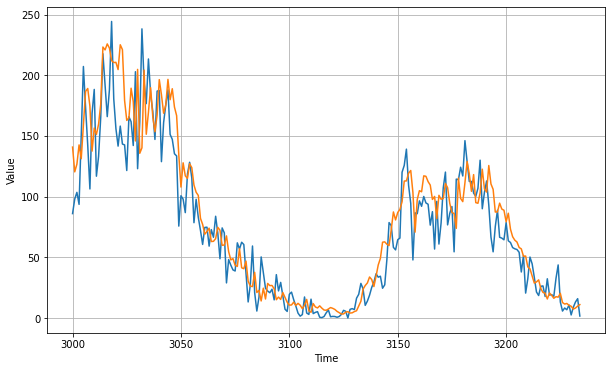

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.54856

<Figure size 432x288 with 0 Axes>

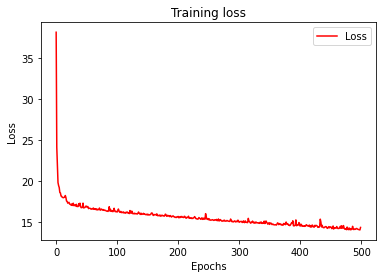

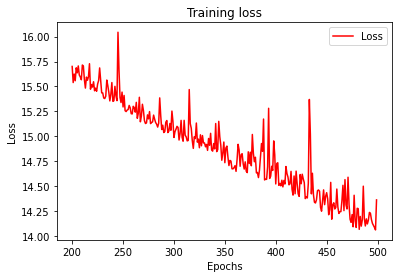

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


# Plot training and validation loss per epoch
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [14]:
print(rnn_forecast)


[140.79292   120.380875  126.720215  142.58751   131.24248   158.57597
 186.64905   189.08621   174.54506   137.47455   156.48106   151.22383
 159.6883    176.24924   223.23808   220.86317   225.79436   222.4172
 212.07497   210.4402    210.62843   204.65587   225.10652   221.11118
 179.15761   162.76433   164.7821    189.30379   178.20622   145.85187
 204.81244   135.67807   140.20235   204.21292   151.36746   169.41917
 189.79942   165.97275   153.42702   167.02388   196.38371   183.922
 168.68948   175.58476   196.5826    179.8482    188.88013   173.8148
 166.69838   134.5154    107.853806  127.827576  117.13605   114.99863
 127.05761   123.83974   109.49431   103.5934    100.947716   82.12227
  77.107216   69.04833    71.34113    73.98457    62.99948    63.153576
  65.38158    74.68489    72.29339    59.878517   60.120617   67.62811
  54.645454   47.821552   48.91842    43.442554   42.469193   57.163094
  41.332825   40.57547    46.850624   30.270885   26.26399    25.874552
  37.58